In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/online_retail.csv')

# Inspect the dataset
print(df.head())
print(df.info())
print(df.describe())


   index InvoiceNo StockCode                          Description  Quantity  \
0      0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1      1    536365     71053                  WHITE METAL LANTERN         6   
2      2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3      3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4      4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       

In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Handle missing values (e.g., drop rows with no CustomerID)
df.dropna(subset=['CustomerID'], inplace=True)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [4]:
# Create a reference date for Recency calculation (e.g., the last date in the dataset)
reference_date = df['InvoiceDate'].max()

# Create RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          2      0.00
12347.0           1        182   4310.00
12348.0          74         31   1797.24
12349.0          18         73   1757.55
12350.0         309         17    334.40


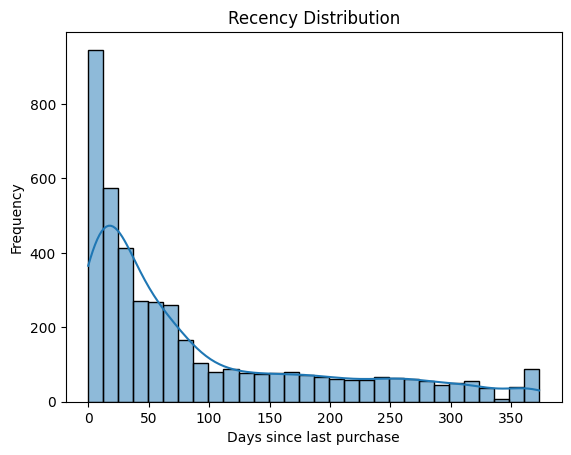

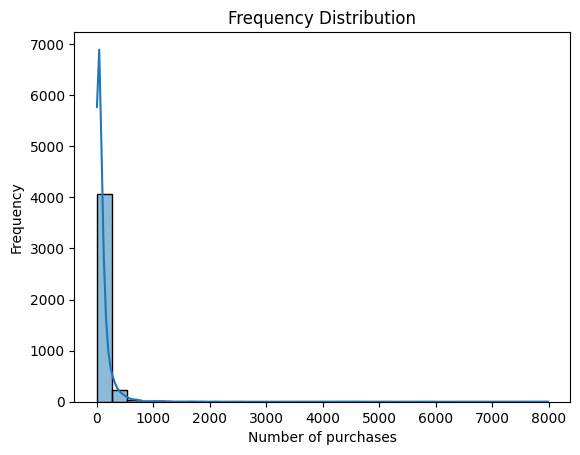

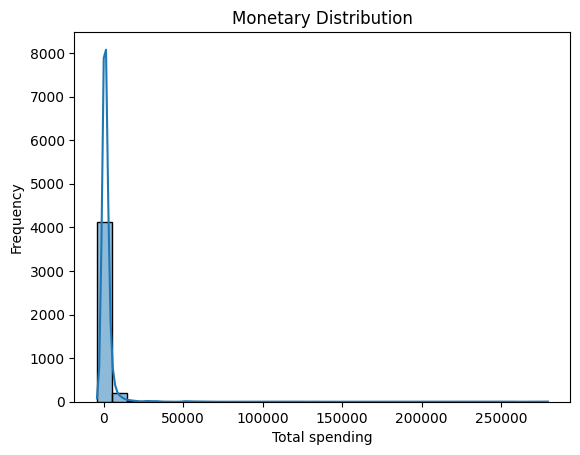

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize Recency distribution
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')
plt.ylabel('Frequency')
plt.show()

# Visualize Frequency distribution
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Number of purchases')
plt.ylabel('Frequency')
plt.show()

# Visualize Monetary distribution
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')
plt.xlabel('Total spending')
plt.ylabel('Frequency')
plt.show()


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


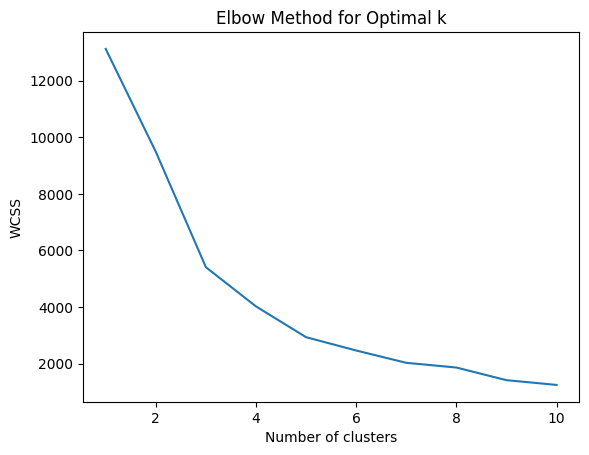

In [7]:
from sklearn.cluster import KMeans

# Determine optimal k using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [8]:
# Fit the K-means model
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


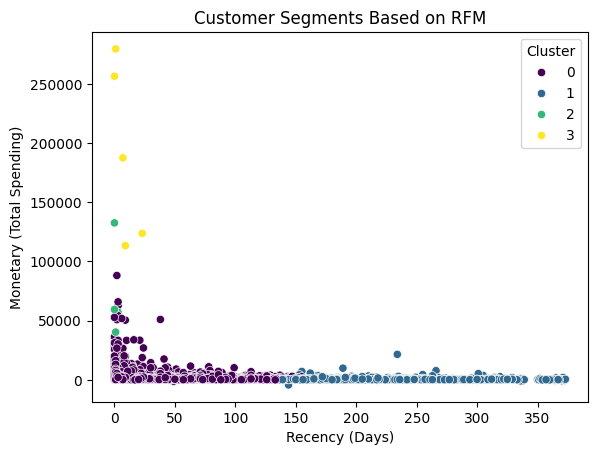

In [9]:
# Plot clusters using Recency and Monetary values
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments Based on RFM')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spending)')
plt.legend(title='Cluster')
plt.show()


In [10]:
# Summarize the clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})
print(cluster_summary)


KeyError: "Column(s) ['CustomerID'] do not exist"

In [11]:
print(rfm.columns.tolist())


['Recency', 'Frequency', 'Monetary', 'Cluster']


In [12]:
print(rfm.head())


            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         325          2      0.00        1
12347.0           1        182   4310.00        0
12348.0          74         31   1797.24        0
12349.0          18         73   1757.55        0
12350.0         309         17    334.40        1


In [13]:
if 'CustomerID' in rfm.columns:
    print("CustomerID column exists")
else:
    print("CustomerID column does NOT exist")


CustomerID column does NOT exist


In [14]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()


In [15]:
# Check the columns in rfm DataFrame
print(rfm.columns.tolist())

# If necessary, strip any leading/trailing whitespace from column names
rfm.columns = rfm.columns.str.strip()

# Check if CustomerID exists
if 'CustomerID' in rfm.columns:
    print("CustomerID column exists")
else:
    print("CustomerID column does NOT exist")

# Grouping by Cluster and aggregating other metrics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_summary)


['Recency', 'Frequency', 'Monetary', 'Cluster']
CustomerID column does NOT exist
   Cluster     Recency    Frequency       Monetary
0        0   39.027931   105.034377    1994.059792
1        1  245.567543    27.770626     464.787073
2        2    0.666667  4821.500000   55039.933333
3        3    8.000000  1013.400000  192103.854000
